In [1]:
import os, time, h5py, platform, json, sys
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from termcolor import cprint
from Common import common
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
with open("Scripts/settings.json") as datafile:
    settings = json.load(datafile)

simulation_name = settings['prelims']['simulation_name']
include_screening = settings['electrostatics']['include_screening']
helium_thickness = settings['electrostatics']['helium_thickness']
screening_length = 2 * helium_thickness
inspect_potentials = settings['prelims']['inspect_potentials']
use_gradient = settings['minimizer']['use_gradient']
gradient_tolerance = settings['minimizer']['gradient_tolerance']
epsilon = settings['minimizer']['epsilon']
if settings['electron_handling']['use_annealing']:
    trap_annealing_steps = [settings['electron_handling']['annealing_temperature']] * settings['electron_handling']['annealing_steps']
else:
    trap_annealing_steps = []
max_x_displacement = settings['electron_handling']['max_x_displacement']
max_y_displacement = settings['electron_handling']['max_y_displacement']
remove_unbound_electrons = settings['electron_handling']['remove_unbounded_electrons']
remove_bounds = settings['electron_handling']['remove_bounds']
show_final_result = settings['prelims']['show_final_result']
create_movie = settings['prelims']['create_movie']
bivariate_spline_smoothing = settings['electrostatics']['bivariate_spline_smoothing']

N_electrons = settings['initial_condition']["N_electrons"]
N_rows = int(settings['initial_condition']['N_rows'])
row_spacing = settings['initial_condition']['row_spacing']
N_cols = settings['initial_condition']['N_cols']
col_spacing = settings['initial_condition']['col_spacing']
box_length = settings['electrostatics']['box_length'] #This is the box length from the simulation in Maxwell.
inserted_res_length = settings['electrostatics']['inserted_res_length'] # This is the length to be inserted in the Maxwell potential; units are in um
inserted_trap_length = settings['electrostatics']['inserted_trap_length'] # This is the length to be inserted in the Maxwell potential; units are in um

In [34]:
v1 = np.arange(-0.10, -0.40, -0.01)
v2 = np.arange(0.42, 0.12, -0.01)

Vrg = np.tile(v1, len(v2))#np.arange(0.00, -0.50-0.005, -0.005)
Vtrap = np.repeat(v2, len(v1))# * np.ones(len(Vrg)) #(0.120 + offset) * np.ones(len(Vrg))

Vres = 0.60 * np.ones(len(Vrg)) #0.600 * np.ones(len(Vrg))
Vtg = -0.00 * np.ones(len(Vrg)) #np.zeros(len(Vrg))
Vcg = None

In [ ]:
len(Vrg)

In [5]:
electrode_names = ['resonator', 'trap', 'res_guard', 'trap_guard']
if Vcg is not None:
    electrode_names.insert(3, 'ctr_guard')

# Determine what electrode will be swept:
sweep_points = np.inf

for SweepIdx, Vpoint in enumerate([Vres, Vtrap, Vrg, Vcg, Vtg]):
    if isinstance(Vpoint, np.ndarray):
        sweep_points = Vpoint
        break

if not(isinstance(sweep_points, np.ndarray)):
    sweep_points = [Vres]
    SweepIdx = 0

cprint("Sweeping %s from %.2f V to %.2f V" % (electrode_names[SweepIdx], sweep_points[0], sweep_points[-1]),
       "green")

electron_initial_positions = anneal.get_rectangular_initial_condition(N_electrons, N_rows=N_rows, N_cols=N_cols,
                                                                      x0=box_length/2.0 + inserted_trap_length + inserted_res_length/2.0,
                                                                      y0=0.0E-6, dx=col_spacing)

Sweeping resonator from 0.60 V to 0.60 V


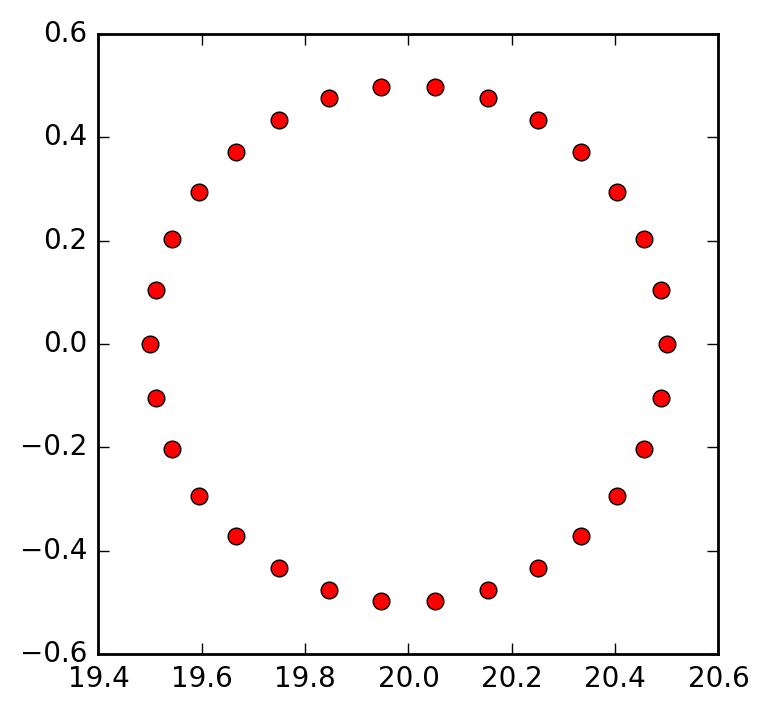

In [6]:
center = (20E-6, 0E-6)
radius = 0.5E-6
N = 30
init_trap_x = [center[0] + radius * np.cos(2*np.pi*i/np.float(N)) for i in range(N)]
init_trap_y = [center[1] + radius * np.sin(2*np.pi*i/np.float(N)) for i in range(N)]

plt.figure(figsize=(4.,4.))
plt.plot(np.array(init_trap_x)*1E6, np.array(init_trap_y)*1E6, 'or')

electron_initial_positions = np.append(electron_initial_positions, 
                                       anneal.xy2r(np.array(init_trap_x), np.array(init_trap_y)))

Trap data was inserted from x = -10.06 um to x = 9.93 um


(-0.49999999999999978, 0.69999999999999996)

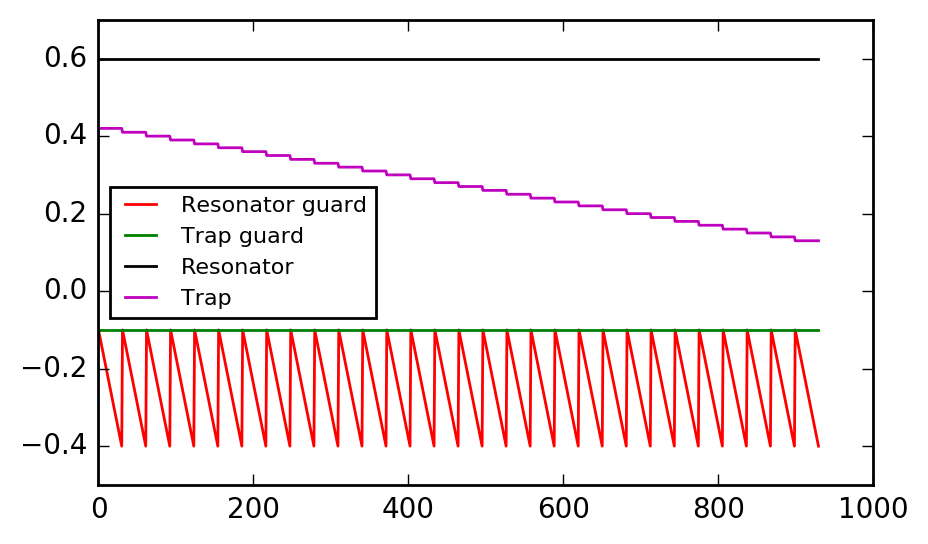

In [8]:
x_trap_init, y_trap_init = anneal.r2xy(electron_initial_positions)

save_path = settings["file_handling"]["save_path"]

sub_dir = time.strftime("%y%m%d_%H%M%S_{}".format(simulation_name))
save = False

# Evaluate all files in the following range.
xeval = np.linspace(-box_length*1E6, box_length*1E6, 2000)
#xeval = np.linspace(-3.3, box_length*1E6, 1000)
yeval = anneal.construct_symmetric_y(-4.0, 201)

dx = np.diff(xeval)[0]*1E-6
dy = np.diff(yeval)[0]*1E-6

master_path = settings["file_handling"]["input_data_path"]

x_eval, y_eval, output = anneal.load_data(master_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                          extend_resonator=False, inserted_trap_length=inserted_trap_length*1E6,
                                          do_plot=inspect_potentials,
                                          inserted_res_length=inserted_res_length*1E6, smoothen_xy=(0.40E-6, 2*dy))

if inspect_potentials:
    plt.show()

# Note: x_eval and y_eval are 2D arrays that contain the x and y coordinates at which the potentials are evaluated
conv_mon_save_path = os.path.join(save_path, sub_dir, "Figures")

fig = plt.figure(figsize=(5., 3.))
plt.plot(Vrg, '-r', label="Resonator guard")
plt.plot(Vtg, '-g', label='Trap guard')
plt.plot(Vres, '-k', label='Resonator')
plt.plot(Vtrap, '-m', label='Trap')
plt.legend(loc=0, prop={"size": 8})
plt.ylim(np.min([np.min(Vrg), np.min(Vtg), np.min(Vres), np.min(Vtrap)])-0.1,
         np.max([np.max(Vrg), np.max(Vtg), np.max(Vres), np.max(Vtrap)])+0.1)

930it [50:28,  3.77s/it]


Number of unbounded electrons = 0


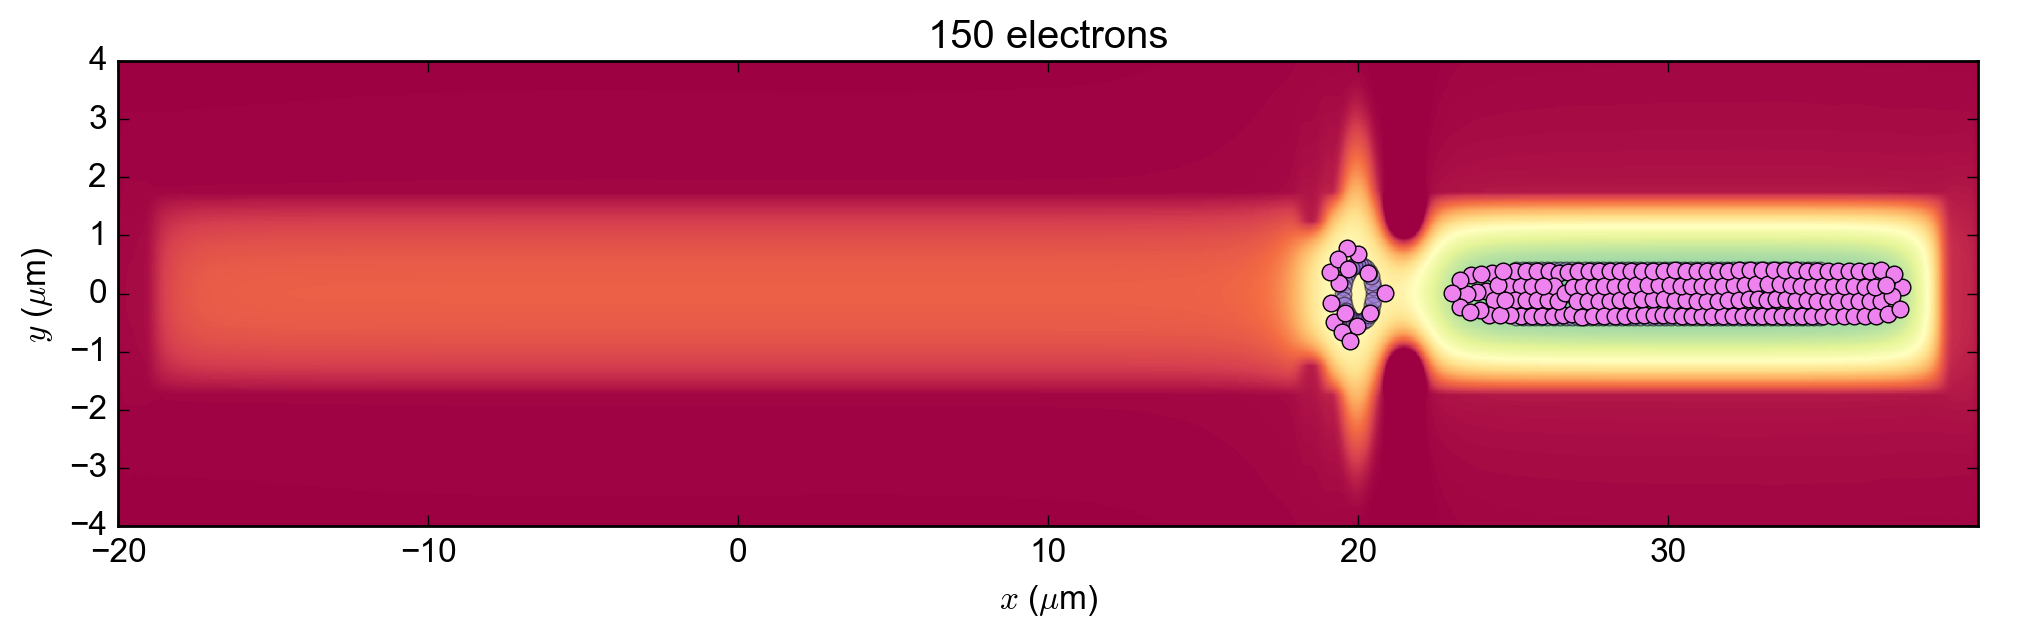

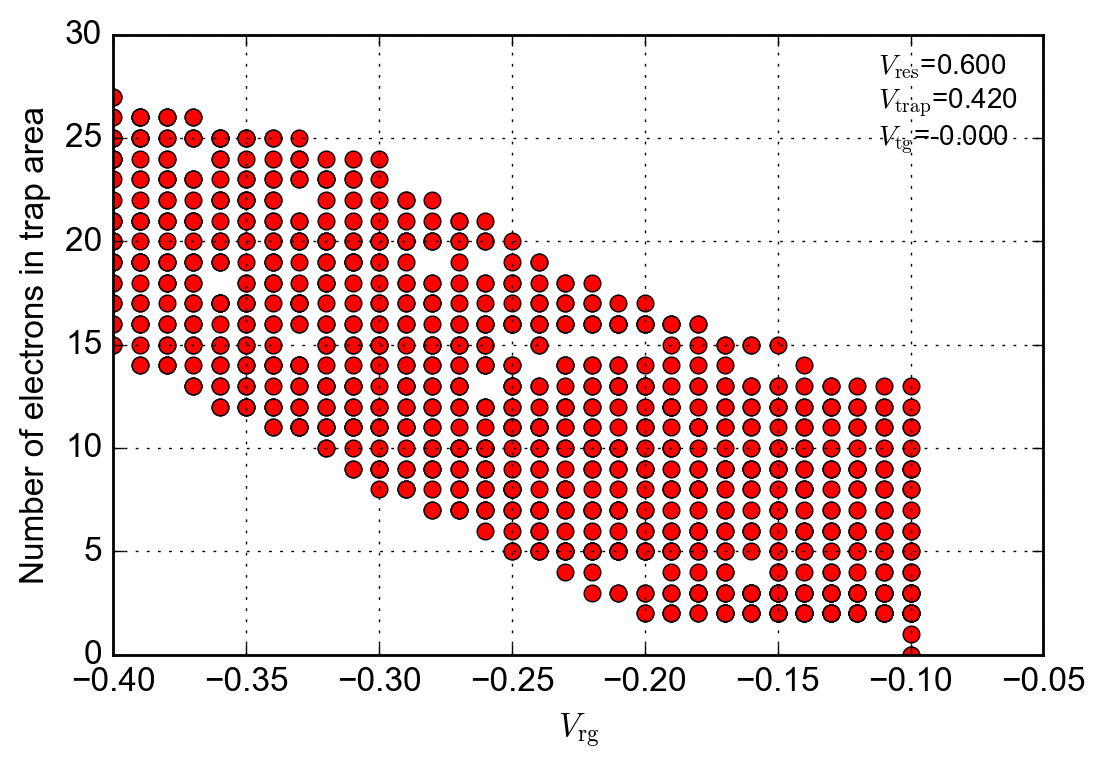

In [35]:
if save:
    # Create the directories
    os.mkdir(os.path.join(save_path, sub_dir))
    time.sleep(1)
    os.mkdir(os.path.join(save_path, sub_dir, "Figures"))
    time.sleep(1)
    os.mkdir(os.path.join(save_path, sub_dir, "2D slice"))
    time.sleep(1)

    common.save_figure(fig, save_path=os.path.join(save_path, sub_dir))

    # Copy settings file to the directory
    copyfile("settings.json", os.path.join(save_path, sub_dir, "settings.json"))

    f = h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "w")
    # Save the data to a single file
    f.create_dataset("use_gradient", data=use_gradient)
    f.create_dataset("gradient_tolerance", data=gradient_tolerance)
    f.create_dataset("include_screening", data=include_screening)
    f.create_dataset("screening_length", data=screening_length)
    f.create_dataset("inserted_res_length", data=inserted_res_length)
    for el_number, el_name in enumerate(electrode_names):
        f.create_dataset(el_name, data=-output[el_number]['V'].T)
    f.create_dataset("xpoints", data=x_eval)
    f.create_dataset("ypoints", data=y_eval)
    f.create_dataset("Vres", data=Vres)
    f.create_dataset("Vtrap", data=Vtrap)
    f.create_dataset("Vrg", data=Vrg)
    if Vcg is not None:
        f.create_dataset("Vcg", data=Vcg)
    f.create_dataset("Vtg", data=Vtg)
    f.close()
    time.sleep(1)


# This is where the actual solving starts...
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

x_eval, y_eval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
electrons_in_the_trap = list()

for k, s in tqdm(enumerate(sweep_points)):
    coefficients = np.array([Vres[k], Vtrap[k], Vrg[k], Vcg, Vtg[k]])
    coefficients[SweepIdx] = s
    if Vcg is None:
        coefficients = np.delete(coefficients, 3)

    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    # Note: x_eval and y_eval are 1D arrays that contain the x and y coordinates at which the potentials are evaluated
    # Units of x_eval and y_eval are um

    CMS = anneal.TrapAreaSolver(x_eval * 1E-6, y_eval * 1E-6, -combined_potential.T,
                                spline_order_x=3, spline_order_y=3, smoothing=bivariate_spline_smoothing,
                                include_screening=include_screening, screening_length=screening_length)

    X_eval, Y_eval = np.meshgrid(x_eval * 1E-6, y_eval * 1E-6)

    # Solve for the electron positions in the trap area!
    ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                        Uext=CMS.V,
                                        xext=xeval * 1E-6, yext=yeval * 1E-6, verbose=False, eps=epsilon,
                                        save_path=None)

    ConvMon.figsize = (8., 2.)

    trap_minimizer_options = {'method' : 'L-BFGS-B',
                              'jac': CMS.grad_total,
                              'options': {'disp': False, 'gtol': gradient_tolerance, 'eps': epsilon},
                              'callback': None}

    # We save the initial Jacobian of the system for purposes.
    initial_jacobian = CMS.grad_total(electron_initial_positions)
    res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)

    while res['status'] > 0:
        # Try removing unbounded electrons and restart the minimization
        if remove_unbound_electrons:
            # Remove any electrons that are to the left of the trap
            best_x, best_y = anneal.r2xy(res['x'])
            idxs = np.where(np.logical_and(best_x > remove_bounds[0], best_x < remove_bounds[1]))[0]
            best_x = np.delete(best_x, idxs)
            best_y = np.delete(best_y, idxs)
            # Use the solution from the current time step as the initial condition for the next timestep!
            electron_initial_positions = anneal.xy2r(best_x, best_y)
            if len(best_x) < len(res['x'][::2]):
                print("%d/%d unbounded electrons removed. %d electrons remain." % (np.int(len(res['x'][::2]) - len(best_x)), len(res['x'][::2]), len(best_x)))
            res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)
        else:
            best_x, best_y = anneal.r2xy(res['x'])
            idxs = np.union1d(np.where(best_x < -2E-6)[0], np.where(np.abs(best_y) > 2E-6)[0])
            if len(idxs) > 0:
                print("Following electrons are outside the simulation domain")
                for i in idxs:
                    print("(x,y) = (%.3f, %.3f) um"%(best_x[i]*1E6, best_y[i]*1E6))
            # To skip the infinite while loop.
            break

    if res['status'] > 0:
        cprint("WARNING: Initial minimization for Trap did not converge!", "red")
        print("Final L-inf norm of gradient = %.2f eV/m" % (np.amax(res['jac'])))
        best_res = res
        if k == 0:
            cprint("Please check your initial condition, are all electrons confined in the simulation area?", "red")
            break

    if len(trap_annealing_steps) > 0:
        # cprint("SUCCESS: Initial minimization for Trap converged!", "green")
        # This maps the electron positions within the simulation domain
        cprint("Perturbing solution %d times at %.2f K. (dx,dy) ~ (%.3f, %.3f) um..." \
              % (len(trap_annealing_steps), trap_annealing_steps[0],
                 np.mean(CMS.thermal_kick_x(res['x'][::2], res['x'][1::2], trap_annealing_steps[0], maximum_dx=max_x_displacement))*1E6,
                 np.mean(CMS.thermal_kick_y(res['x'][::2], res['x'][1::2], trap_annealing_steps[0], maximum_dy=max_y_displacement))*1E6),
               "white")
        best_res = CMS.perturb_and_solve(CMS.Vtotal, len(trap_annealing_steps), trap_annealing_steps[0],
                                         res, maximum_dx=max_x_displacement, maximum_dy=max_y_displacement, 
                                         **trap_minimizer_options)
    else:
        best_res = res

    if 1:
        electron_pos = best_res['x'][::2] * 1E6

        voltage_labels = "$V_\mathrm{res}$ = %.2f V\n$V_\mathrm{trap}$ = %.2f V\n$V_\mathrm{rg}$ = %.2f V\n$V_\mathrm{tg}$ = %.2f V" \
                         % (coefficients[0], coefficients[1], coefficients[2], coefficients[3])

        fig = plt.figure(figsize=(7., 3.))
        common.configure_axes(13)
        plt.plot(x_eval, CMS.V(x_eval * 1E-6, 0), '-', lw=0, color='orange', label=voltage_labels)
        plt.plot(x_eval, CMS.V(x_eval * 1E-6, 0), '-', color='orange')
        plt.plot(best_res['x'][::2] * 1E6, CMS.calculate_mu(best_res['x']), 'o', mec='none',
                 ms=4, color='cornflowerblue')
        plt.xlabel("$x$ ($\mu$m)")
        plt.ylabel("Potential energy (eV)")
        plt.title("%s = %.2f V" % (electrode_names[SweepIdx], coefficients[SweepIdx]))
        if k == 0:
            lims = plt.ylim()
        plt.ylim(lims)
        plt.xlim(-7 + inserted_trap_length*1E6, 7 + inserted_trap_length*1E6)
        plt.legend(loc=1, numpoints=1, frameon=False, prop={'size' : 10})

        if save:
            common.save_figure(fig, save_path=os.path.join(save_path, sub_dir, "2D slice"))

        plt.close(fig)

    def magE(x, y):
        return np.log10(np.sqrt(CMS.dVdx(x, y)**2 + CMS.dVdy(x, y)**2))

#     PP = anneal.PostProcess(save_path=conv_mon_save_path)
    x_plot = np.arange(-7E-6, +7E-6, dx) + inserted_trap_length
    y_plot = y_eval*1E-6
#     PP.save_snapshot(best_res['x'], xext=x_plot, yext=y_plot, Uext=magE,
#                      figsize=(6.5, 3.), common=common, 
#                      title="Gradient at %s = %.3f V" % (electrode_names[SweepIdx], coefficients[SweepIdx]),
#                      clim=(1.5, 6.0),
#                      draw_resonator_pins=False,
#                      draw_from_dxf={'filename' : os.path.join(master_path, 'all_electrodes.dxf'),
#                                     'offset' : (inserted_trap_length*1E6, 0E-6),
#                                     'plot_options' : {'color' : 'black', 'alpha' : 0.6, 'lw' : 0.5}})
    
    if save:
        f = h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "a")
        f.create_dataset("step_%04d/initial_jacobian" % k, data=initial_jacobian)
        f.create_dataset("step_%04d/final_jacobian" % k, data=best_res['jac'])
        f.create_dataset("step_%04d/electron_initial_coordinates" % k, data=electron_initial_positions)
        f.create_dataset("step_%04d/electron_final_coordinates" % k, data=best_res['x'])
        f.create_dataset("step_%04d/final_energy" % k, data=best_res['fun'])
        f.create_dataset("step_%04d/solution_converged" % k, data=True if best_res['status'] == 0 else False)
        f.create_dataset("step_%04d/electrons_in_trap" % k,
                         data=PP.get_trapped_electrons(best_res['x'], trap_area_x=(-1.2E-6, +1.2E-6)))
        f.create_dataset("step_%04d/mu" % k, data=CMS.calculate_mu(best_res['x']))

        f.close()

    # Use the solution from the current time step as the initial condition for the next timestep!
#     electron_initial_positions = best_res['x']
    ex, ey = anneal.r2xy(best_res['x'])
    electrons_in_the_trap.append(np.sum(np.logical_and(ex<21.5E-6, ex>18.0E-6)))
    
    if 0:
        fig = plt.figure(figsize=(8.,3.))
        common.configure_axes(13)
        plt.plot(x_eval, CMS.V(x_eval*1E-6, 0), '-k')
        plt.plot(ex * 1E6, CMS.calculate_mu(best_res['x']), 
                 'o', color='violet', alpha=1)
        plt.xlabel("$x$ ($\mu$m)")
        plt.ylabel("Potential energy (eV)")
        plt.xlim(18, 28)
        plt.ylim(-0.35, -Vtrap[k]*0.60)
        plt.vlines([18, 21.5], -0.35, -Vtrap*0.60, linestyles='--', color='k')
        plt.show()

trap_electrons_x, trap_electrons_y = anneal.r2xy(best_res['x'])

if create_movie:
    try:
        # Create a movie
        ConvMon.create_movie(fps=10,
                             filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png",
                             filename_out=simulation_name + ".mp4")

        # Move the file from the Figures folder to the sub folder
        os.rename(os.path.join(save_path, sub_dir, "Figures", simulation_name + ".mp4"),
                  os.path.join(save_path, sub_dir, simulation_name + ".mp4"))

        # Create a movie of the 2D slices
        ConvMon.save_path = os.path.join(save_path, sub_dir, "2D slice")
        ConvMon.create_movie(fps=10,
                             filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png",
                             filename_out=simulation_name + ".mp4")

        # Move the file from the 2D slice folder to the sub folder
        os.rename(os.path.join(save_path, sub_dir, "2D slice", simulation_name + ".mp4"),
                  os.path.join(save_path, sub_dir, simulation_name + "_2D_slice.mp4"))
    except:
        print("Failed making a movie!")

if show_final_result:
    # Plot the resonator and trap electron configuration
    fig2 = plt.figure(figsize=(12, 3))
    common.configure_axes(12)
    plt.pcolormesh(x_eval, y_eval, CMS.V(X_eval, Y_eval), cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.75 * np.max(Vres))
    plt.plot(x_trap_init * 1E6, y_trap_init * 1E6, 'o', color='mediumpurple', alpha=0.5)
    plt.plot(trap_electrons_x * 1E6, trap_electrons_y * 1E6, 'o', color='violet', alpha=1.0)

    if best_res['status'] > 0:
       plt.text(2, -2, "Minimization did not converge", fontdict={"size" : 10})

    plt.xlabel("$x$ ($\mu$m)")
    plt.ylabel("$y$ ($\mu$m)")
    plt.title("%d electrons" % (N_electrons))
    plt.xlim(np.min(x_eval), np.max(x_eval))
    plt.ylim(np.min(y_eval), np.max(y_eval))

    if save:
        common.save_figure(fig2, save_path=os.path.join(save_path, sub_dir))

    num_unbounded_electrons = anneal.check_unbounded_electrons(best_res['x'],
                                                               xdomain=(np.min(x_eval) * 1E-6, np.max(x_eval) * 1E-6),
                                                               ydomain=(np.min(y_eval) * 1E-6, np.max(y_eval) * 1E-6))

    print("Number of unbounded electrons = %d" % num_unbounded_electrons)

    plt.show()
        
    fig = plt.figure()
    plt.plot(Vrg, electrons_in_the_trap, 'or', 
             label="$V_\mathrm{res}$=%.3f\n$V_\mathrm{trap}$=%.3f\n$V_\mathrm{tg}$=%.3f"%(Vres[0], Vtrap[0], Vtg[0]))
    plt.xlabel("$V_\mathrm{rg}$")
    plt.ylabel("Number of electrons in trap area")
    plt.legend(loc=0, prop={"size":10}, markerscale=0, frameon=False)
    plt.ylim(0, 30)
    plt.grid()

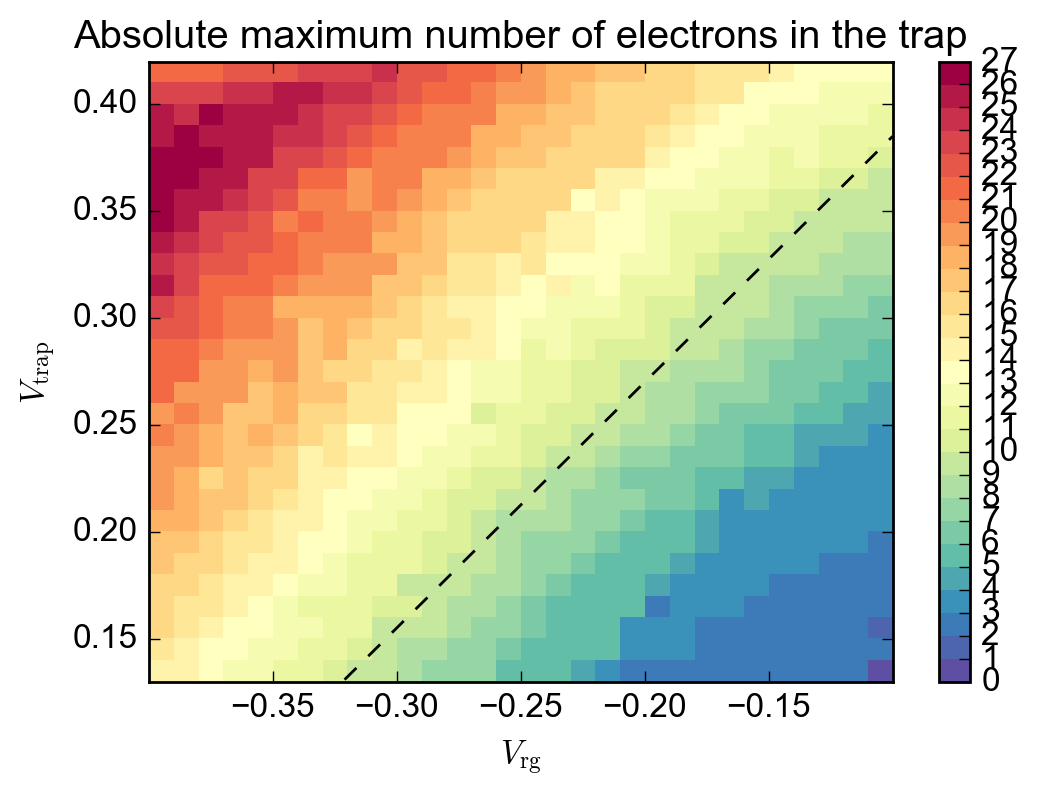

In [36]:
plt.figure()
plt.pcolormesh(v1, v2, np.reshape(electrons_in_the_trap, (len(v2), len(v1))), 
               cmap=plt.cm.get_cmap("Spectral_r", np.max(np.array(electrons_in_the_trap))), 
               vmax=np.max(electrons_in_the_trap), vmin=0)
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
plt.title("Absolute maximum number of electrons in the trap")
plt.xlim(np.min(v1), np.max(v1))
plt.ylim(np.min(v2), np.max(v2))
cbar = plt.colorbar()
cbar.set_ticks(range(0, np.max(electrons_in_the_trap)+1))

xje = np.linspace(-0.40, -0.10)
yje = 0.50 + 1.15*xje
plt.plot(xje, yje, '--k')

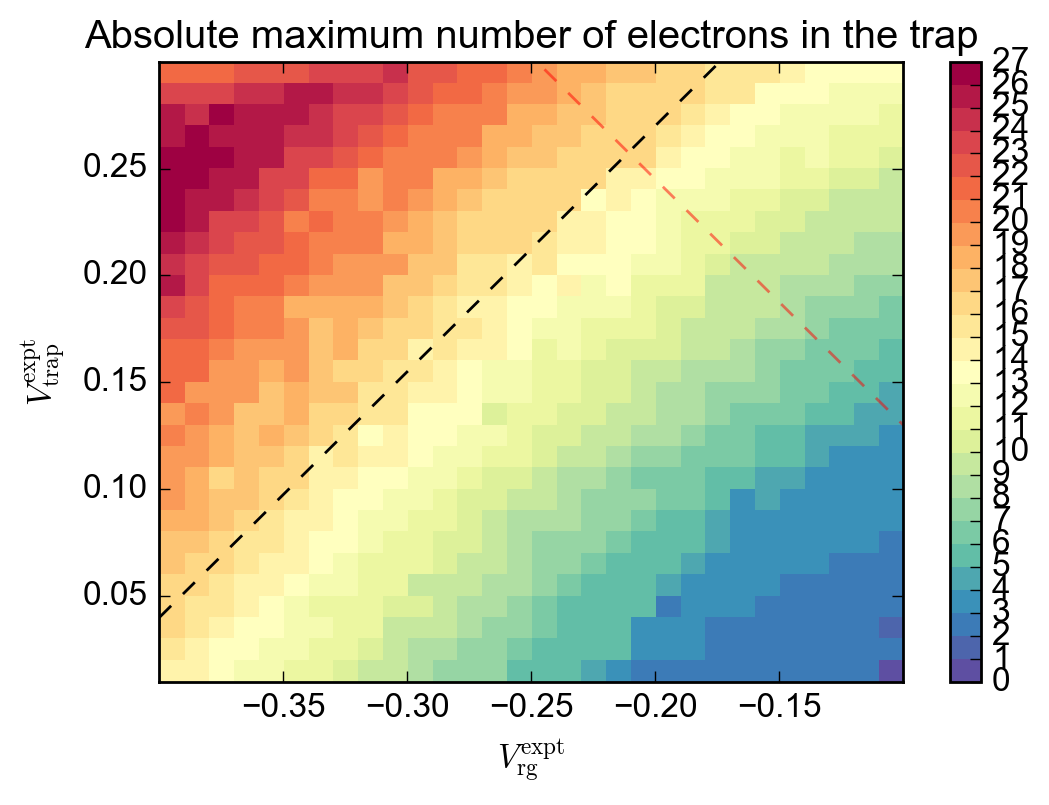

In [38]:
plt.figure()
plt.pcolormesh(v1, v2-0.120, np.reshape(electrons_in_the_trap, (len(v2), len(v1))), 
               cmap=plt.cm.get_cmap("Spectral_r", np.max(np.array(electrons_in_the_trap))), 
               vmax=np.max(electrons_in_the_trap), vmin=0)
plt.xlabel(r"$V_\mathrm{rg}^\mathrm{expt}$")
plt.ylabel(r"$V_\mathrm{trap}^\mathrm{expt}$")
plt.title("Absolute maximum number of electrons in the trap")
plt.xlim(np.min(v1), np.max(v1))
plt.ylim(np.min(v2)-0.120, np.max(v2)-0.120)
cbar = plt.colorbar()
cbar.set_ticks(range(0, np.max(electrons_in_the_trap)+1))

xje = np.linspace(-0.40, -0.10)
yje = 0.50 + 1.15*xje
plt.plot(xje, yje, '--k')

mu = -0.270
f_mu = -1.755-7*mu
plt.plot(xje, -1.15*xje + f_mu - 0.120, '--', color='r', alpha=0.5)

In [49]:
common.get_noof_photons_in_cavity(-95, 6.4E9, 10000)

18536.505128919132

In [41]:
7.684E9/1E6

7684.0